In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
import optuna
from optuna.integration import lightgbm as lgb
from utils import evaluate_binary_clf, feature_transformer, DEFAULT_VALS

%load_ext autoreload
%autoreload 2

In [2]:
X_train = pd.read_parquet("./modelling_data/X_train.parquet")
y_train = pd.read_parquet("./modelling_data/y_train.parquet")
X_test = pd.read_parquet("./modelling_data/X_test.parquet")
y_test = pd.read_parquet("./modelling_data/y_test.parquet")

X_train["Month"] = X_train["Date"].dt.month
X_test["Month"] = X_test["Date"].dt.month
X_train.drop(columns=["Date"], inplace=True)
X_test.drop(columns=["Date"], inplace=True)

In [3]:
X_train.update(X_train.groupby("Location").ffill())
X_test.update(X_test.groupby("Location").ffill())

for col in X_train:
    X_train[col] = X_train[col].fillna(DEFAULT_VALS.get(col, np.nan))

for col in X_test:
    X_test[col] = X_test[col].fillna(DEFAULT_VALS.get(col, np.nan))

cols_to_lag = ["Temp9am", "Temp3pm", "Humidity9am", "Humidity3pm", "Pressure9am", "Pressure3pm"]

shifted = X_train.groupby("Location")[cols_to_lag].shift(1)
shifted.columns = shifted.columns.map(lambda c: f"{c}_LAG1")
X_train = X_train.merge(shifted, left_index=True, right_index=True)

shifted = X_test.groupby("Location")[cols_to_lag].shift(1)
shifted.columns = shifted.columns.map(lambda c: f"{c}_LAG1")
X_test = X_test.merge(shifted, left_index=True, right_index=True)

shifted = X_train.groupby("Location")[cols_to_lag].shift(2)
shifted.columns = shifted.columns.map(lambda c: f"{c}_LAG2")
X_train = X_train.merge(shifted, left_index=True, right_index=True)

shifted = X_test.groupby("Location")[cols_to_lag].shift(2)
shifted.columns = shifted.columns.map(lambda c: f"{c}_LAG2")
X_test = X_test.merge(shifted, left_index=True, right_index=True)
    
X_train = feature_transformer(X_train)
X_test = feature_transformer(X_test)

In [13]:
%%capture

optuna.logging.set_verbosity(optuna.logging.ERROR)

study = optuna.create_study()

params = {
    "objective": "binary",
    "metric": "binary_error",
    "verbose": -1,
    "boosting_type": "gbdt"
}

dtrain = lgb.Dataset(X_train.drop(columns=["Location"]), y_train["RainTomorrow"])

tuner = lgb.LightGBMTunerCV(
    params=params,
    train_set=dtrain,
    study=study,
    early_stopping_rounds=25,
    folds=TimeSeriesSplit(n_splits=3),
    shuffle=False,
    time_budget=360,
    return_cvbooster=True,
    show_progress_bar=False
)

tuner.run()

In [14]:
tuner.best_params

{'objective': 'binary',
 'metric': 'binary_error',
 'verbose': -1,
 'boosting_type': 'gbdt',
 'feature_pre_filter': False,
 'lambda_l1': 0.0001038116468070766,
 'lambda_l2': 4.605798667644331e-05,
 'num_leaves': 70,
 'feature_fraction': 0.4,
 'bagging_fraction': 1.0,
 'bagging_freq': 0,
 'min_child_samples': 20}

In [15]:
tuner.best_score

0.14554794520547945

In [16]:
study.best_params

{'lambda_l1': 0.0001038116468070766, 'lambda_l2': 4.605798667644331e-05}

In [17]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_bagging_fraction,params_bagging_freq,params_feature_fraction,params_lambda_l1,params_lambda_l2,params_min_child_samples,params_num_leaves,system_attrs_grid_id,system_attrs_lightgbm_tuner:average_iteration_time,system_attrs_lightgbm_tuner:elapsed_secs,system_attrs_lightgbm_tuner:lgbm_params,system_attrs_lightgbm_tuner:step_name,system_attrs_search_space,state
0,0,0.146439,2021-03-19 21:19:07.837093,2021-03-19 21:19:09.912071,00:00:02.074978,NaN,NaN,1.0,NaN,NaN,NaN,NaN,6.0,0.015599,2.074656,"{""objective"": ""binary"", ""metric"": ""binary_erro...",feature_fraction,"{'feature_fraction': [0.4, 0.5, 0.6, 0.7, 0.8,...",COMPLETE
1,1,0.146084,2021-03-19 21:19:09.912124,2021-03-19 21:19:11.920604,00:00:02.008480,NaN,NaN,0.8,NaN,NaN,NaN,NaN,4.0,0.015418,1.973477,"{""objective"": ""binary"", ""metric"": ""binary_erro...",feature_fraction,"{'feature_fraction': [0.4, 0.5, 0.6, 0.7, 0.8,...",COMPLETE
2,2,0.145868,2021-03-19 21:19:11.920649,2021-03-19 21:19:13.479090,00:00:01.558441,NaN,NaN,0.4,NaN,NaN,NaN,NaN,0.0,0.016024,1.522235,"{""objective"": ""binary"", ""metric"": ""binary_erro...",feature_fraction,"{'feature_fraction': [0.4, 0.5, 0.6, 0.7, 0.8,...",COMPLETE
3,3,0.146006,2021-03-19 21:19:13.479134,2021-03-19 21:19:15.642220,00:00:02.163086,NaN,NaN,0.5,NaN,NaN,NaN,NaN,1.0,0.013040,2.125490,"{""objective"": ""binary"", ""metric"": ""binary_erro...",feature_fraction,"{'feature_fraction': [0.4, 0.5, 0.6, 0.7, 0.8,...",COMPLETE
4,4,0.145920,2021-03-19 21:19:15.642268,2021-03-19 21:19:17.834266,00:00:02.191998,NaN,NaN,0.6,NaN,NaN,NaN,NaN,2.0,0.012468,2.156923,"{""objective"": ""binary"", ""metric"": ""binary_erro...",feature_fraction,"{'feature_fraction': [0.4, 0.5, 0.6, 0.7, 0.8,...",COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,60,0.146041,2021-03-19 21:21:41.756415,2021-03-19 21:21:44.347826,00:00:02.591411,NaN,NaN,NaN,NaN,NaN,50.0,NaN,3.0,0.023164,2.548027,"{""objective"": ""binary"", ""metric"": ""binary_erro...",min_data_in_leaf,"{'min_child_samples': [5, 10, 25, 50, 100]}",COMPLETE
61,61,0.146473,2021-03-19 21:21:44.347897,2021-03-19 21:21:46.822587,00:00:02.474690,NaN,NaN,NaN,NaN,NaN,5.0,NaN,0.0,0.026700,2.429667,"{""objective"": ""binary"", ""metric"": ""binary_erro...",min_data_in_leaf,"{'min_child_samples': [5, 10, 25, 50, 100]}",COMPLETE
62,62,0.145747,2021-03-19 21:21:46.822663,2021-03-19 21:21:49.797803,00:00:02.975140,NaN,NaN,NaN,NaN,NaN,10.0,NaN,1.0,0.022560,2.932850,"{""objective"": ""binary"", ""metric"": ""binary_erro...",min_data_in_leaf,"{'min_child_samples': [5, 10, 25, 50, 100]}",COMPLETE
63,63,0.145799,2021-03-19 21:21:49.797879,2021-03-19 21:21:52.984852,00:00:03.186973,NaN,NaN,NaN,NaN,NaN,100.0,NaN,4.0,0.021388,3.143972,"{""objective"": ""binary"", ""metric"": ""binary_erro...",min_data_in_leaf,"{'min_child_samples': [5, 10, 25, 50, 100]}",COMPLETE


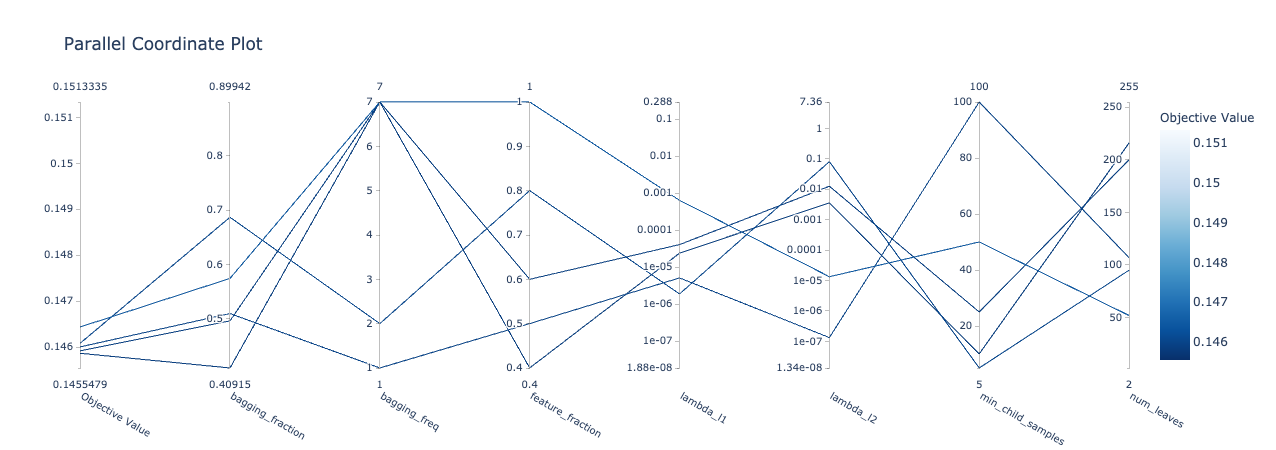

In [18]:
optuna.visualization.plot_parallel_coordinate(study)

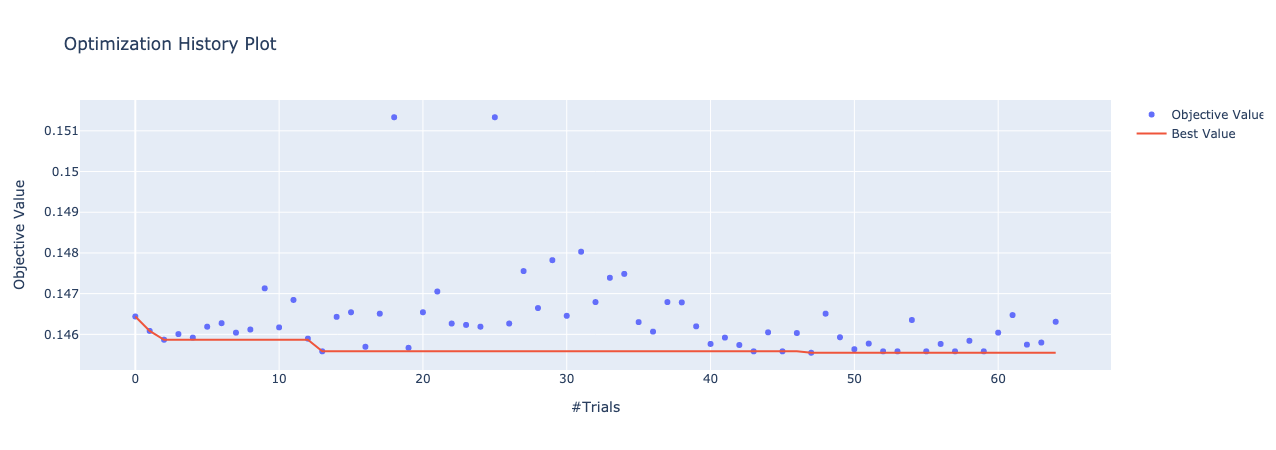

In [19]:
optuna.visualization.plot_optimization_history(study)

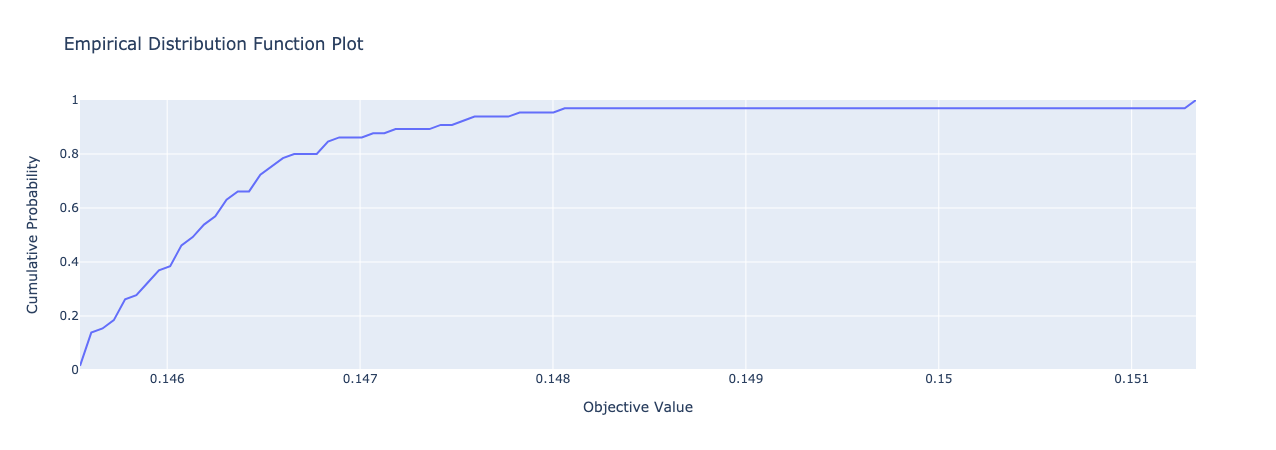

In [20]:
optuna.visualization.plot_edf(study)

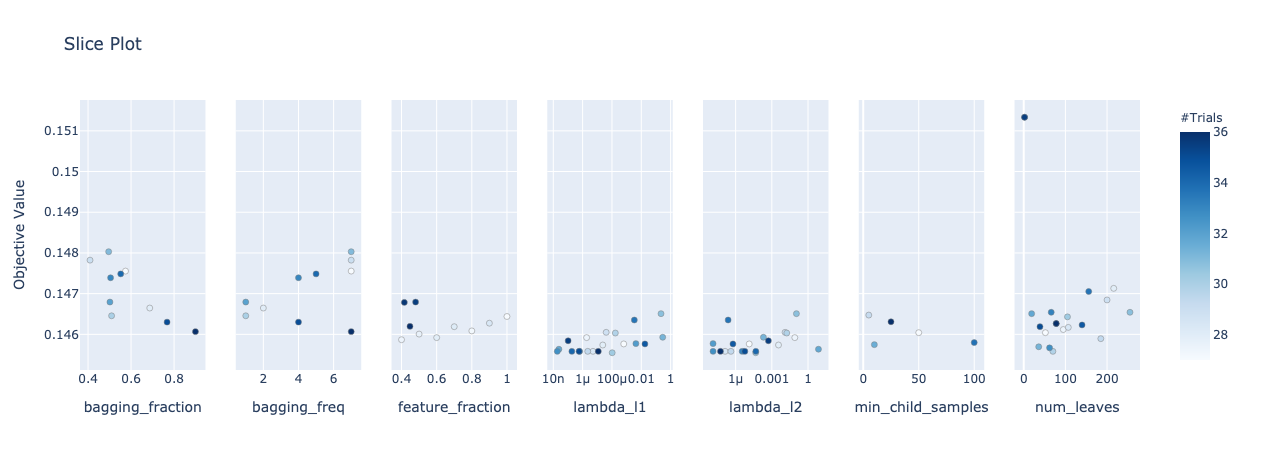

In [21]:
optuna.visualization.plot_slice(study)